In [2]:
# Chest X-Ray Classification Pipeline

import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report)

In [3]:
# Config
EXTRACT_DIR = Path("./chest_xray")   # path to dataset folder
IMAGE_SIZE = (128, 128)
RANDOM_STATE = 42
TEST_SIZE = 0.15
VAL_SIZE = 0.15

HOG_PARAMS = {
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'orientations': 9,
    'block_norm': 'L2-Hys'
}

LBP_PARAMS = {'P': 8, 'R': 1, 'method': 'uniform'}
GLCM_DISTANCES = [1]
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]
GLCM_PROPS = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']


In [4]:
# Helper Functions
def gather_image_paths(base_dir: Path):
    image_paths = []
    for subset in ['train', 'val', 'test']:
        d = base_dir / subset
        if not d.exists():
            continue
        for label_dir in d.iterdir():
            if label_dir.is_dir():
                for img in label_dir.glob("*.jpeg"):
                    image_paths.append((img, label_dir.name, subset))
    return pd.DataFrame(image_paths, columns=["path","label","split"])

def load_gray(path):
    img = Image.open(path).convert("L").resize((IMAGE_SIZE[1], IMAGE_SIZE[0]))
    return np.array(img, dtype=np.uint8)

def extract_hog(gray): 
    return hog(gray, **HOG_PARAMS)

def extract_lbp(gray):
    lbp = local_binary_pattern(gray, LBP_PARAMS['P'], LBP_PARAMS['R'], method=LBP_PARAMS['method'])
    hist, _ = np.histogram(lbp.ravel(), bins=59, range=(0,59))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

def extract_glcm(gray):
    img_q = (gray / (256//8)).astype('uint8')
    glcm = graycomatrix(img_q, distances=GLCM_DISTANCES, angles=GLCM_ANGLES, levels=8, symmetric=True, normed=True)
    return np.array([graycoprops(glcm, prop).mean() for prop in GLCM_PROPS])

def build_features(gray): 
    return np.concatenate([extract_hog(gray), extract_lbp(gray), extract_glcm(gray)])


In [5]:
# Load dataset
df = gather_image_paths(EXTRACT_DIR)
print("Images:", len(df))
print(df["label"].value_counts())

# Extract features
X, y = [], []
for _, row in tqdm(df.iterrows(), total=len(df)):
    gray = load_gray(row["path"])
    feat = build_features(gray)
    X.append(feat)
    y.append(0 if row["label"].lower()=="normal" else 1)

X, y = np.vstack(X), np.array(y)
print("Feature matrix:", X.shape)


Images: 5856
label
PNEUMONIA    4273
NORMAL       1583
Name: count, dtype: int64


100%|██████████| 5856/5856 [00:32<00:00, 180.76it/s]

Feature matrix: (5856, 8165)


In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

val_rel = VAL_SIZE / (1 - TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_rel, stratify=y_train_val, random_state=RANDOM_STATE)

scaler = StandardScaler()
X_train_s, X_val_s, X_test_s = scaler.fit_transform(X_train), scaler.transform(X_val), scaler.transform(X_test)


In [7]:
def evaluate(name, model, X_t, y_t, save_plot=False):
    y_pred = model.predict(X_t)
    y_prob = model.predict_proba(X_t)[:,1] if hasattr(model,"predict_proba") else None
    
    print(f"\n{name} Classification Report:\n", classification_report(y_t, y_pred, target_names=["Normal","Pneumonia"]))
    
    cm = confusion_matrix(y_t, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal","Pneumonia"], yticklabels=["Normal","Pneumonia"])
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    
    if save_plot:
        plt.savefig(f"confusion_matrix_{name.replace(' ','_')}.png")
    
    return {
        "accuracy": accuracy_score(y_t,y_pred),
        "precision": precision_score(y_t,y_pred),
        "recall": recall_score(y_t,y_pred),
        "f1": f1_score(y_t,y_pred),
        "auc": roc_auc_score(y_t,y_prob) if y_prob is not None else None
    }



Logistic Regression Classification Report:
               precision    recall  f1-score   support

      Normal       0.92      0.90      0.91       238
   Pneumonia       0.96      0.97      0.97       641

    accuracy                           0.95       879
   macro avg       0.94      0.93      0.94       879
weighted avg       0.95      0.95      0.95       879



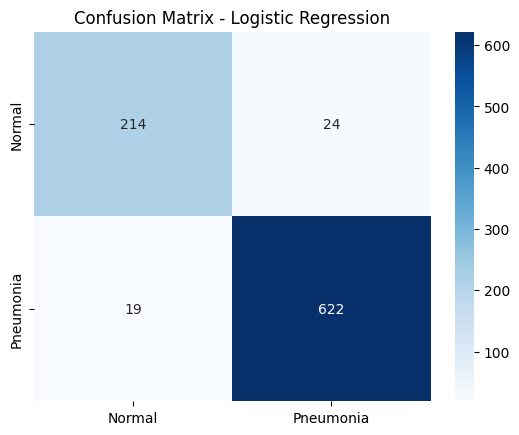


Decision Tree Classification Report:
               precision    recall  f1-score   support

      Normal       0.84      0.81      0.82       238
   Pneumonia       0.93      0.94      0.94       641

    accuracy                           0.91       879
   macro avg       0.88      0.88      0.88       879
weighted avg       0.91      0.91      0.91       879



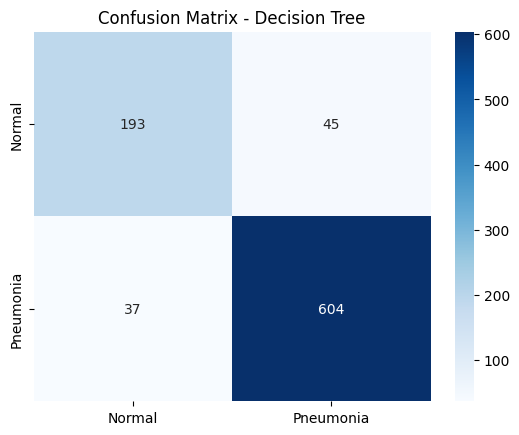


Random Forest Classification Report:
               precision    recall  f1-score   support

      Normal       0.89      0.88      0.88       238
   Pneumonia       0.95      0.96      0.96       641

    accuracy                           0.94       879
   macro avg       0.92      0.92      0.92       879
weighted avg       0.94      0.94      0.94       879



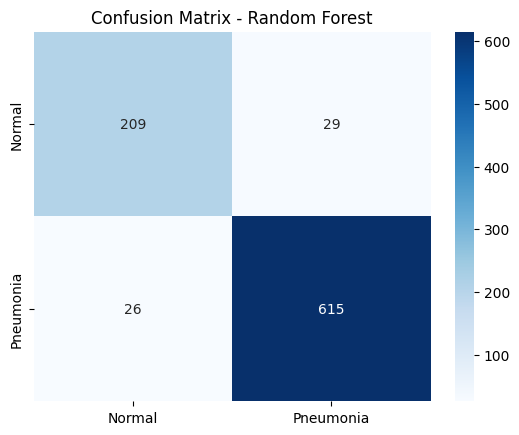

<Figure size 640x480 with 0 Axes>

In [8]:
results = {}

# Logistic Regression
lr = LogisticRegression(max_iter=2000).fit(X_train_s, y_train)
results["Logistic Regression"] = evaluate("Logistic Regression", lr, X_test_s, y_test, save_plot=True)

# Decision Tree
dt = DecisionTreeClassifier(max_depth=10, random_state=RANDOM_STATE).fit(X_train, y_train)
results["Decision Tree"] = evaluate("Decision Tree", dt, X_test, y_test, save_plot=True)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=RANDOM_STATE).fit(X_train, y_train)
results["Random Forest"] = evaluate("Random Forest", rf, X_test, y_test, save_plot=True)


In [9]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
display(results_df)

# Save metrics to CSV
results_df.to_csv("metrics_table.csv", index=True)
print("✅ Metrics table saved as metrics_table.csv")



Model Comparison:


,accuracy,precision,recall,f1,auc
Logistic Regression,0.951081,0.962848,0.970359,0.966589,0.982557
Decision Tree,0.906712,0.930663,0.942278,0.936434,0.813874
Random Forest,0.937429,0.954969,0.959438,0.957198,0.976940


✅ Metrics table saved as metrics_table.csv
